In [1]:
import pandas as pd
import matplotlib.axes as ax
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

## Executive Summary

Military coups have existed since as far `back` as 800 BC. They occur when an illegitimate claimant to power seizes power within a state for at least seven days. Although coups have been fewer in recent time, there have been about 460 coup~~s~~ attempts since 1950 (of which roughly 50% were successful). In `the` past century, coups have been mostly common in Africa and the Americas, with fewer coups occurring Europe. Most of the coup attempts in the past 60 years occurred in the 1960s, at the same time~~s~~ `that the` majority of African nations gained independece from the Europeans. However, in recent times, successful coups have been less frequent either because governments have developed new methods in containing the usurpers, or because recent coup leaders are less strategic in claiming the throne. That, however, is a data science question for another project. 

Although successful coups are more prominent, attempted coups are more frequent than one would expect. In the past 16 years along, there have been 30 attempted coups (seven successful), with `the` majority occurring in Africa. Many of these coup attemp`t`s did not gain as much international attention as that of Turkey that occurred July 15, 2016. The recent coup~~s~~ attempts causes one to wonder if there `are` ways to predict a coup attempt (successful or not), given the social and poli`ti`cal climate in a state.

Problem Statement: Consideri`n`g social and political instabilities that have occured in recent times, I want predict the likelihood of a coup d'etat within a country, given specific economic, political and social factors.

- Economic factors: income per capita, growth rate
- Social factors: accounts of ethnic violence, reglious, linguistic, and ethnic fractionalization, fatalities from violence, urbanisation
- Political factors: polity score, length of stay for incumbent head of state


For my analysis, I will be using a Random Forest Classifier model to predict the occurrence of a coup. The dataset consist of 3046 observations and 20 variables. 
  

In [69]:
# I'm still in the process of building my model. I'll also add more visualizations

In [2]:
coup = pd.read_csv("../assets/csv/Coups.csv")
stab = pd.read_csv("../assets/csv/Politicalinstability2.csv")
polity = pd.read_csv("../assets/csv/polity.csv")
leaders = pd.read_csv("../assets/csv/leaders.csv")
urban = pd.read_csv("../assets/csv/urbanpop.csv")
gdp = pd.read_csv("../assets/csv/Realpercapitagdp.csv")
growth = pd.read_csv("../assets/csv/GDPgrowth.csv")

In [3]:
#coup.head()

In [4]:
# Summing scoup1(successful coups) and acoup1(attempted coups) to generate sumcoup
# I want a columns with binary variables that indicates coup (successful and attempted) or no coup
coup["sumcoup"] = coup["scoup1"] + coup["atcoup2"]

# To make a bianry column
coupbin = []
for i in coup["sumcoup"].tolist():
    if i > 0:
        coupbin.append(1)
    if i == 0:
        coupbin.append(0)
coup["Coup"] = coupbin

In [5]:
# Dropping unnecessary columns
coup.drop(["scoup1", "atcoup2", "sumcoup"], axis=1, inplace=True)

In [6]:
#stab.head()

In [7]:
# To covert the variables in PTYPE to dummy variables 
dummies = pd.get_dummies(stab["PTYPE"])
stab = stab[["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
             "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT"]].join(dummies)

stab.columns = ["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
                "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT", "NONE",
                "ETH", "REV", "GEN"]

In [8]:
# To avoid repetition of rows, I want to group the dataframes bq
aggMap = { "NONE" : "sum", "ETH" : "sum", "REV" : "sum", 
           "GEN" : "sum", "GENDEATHMAG" : "sum", 
           "ETHMAGFATAL" : "sum", "ETHMAGFIGHT" : "sum", 
           "REVMAGFATAL" : "sum", "REVMAGFIGHT" : "sum" }

stabGrouped = stab.groupby(["COUNTRY","YEAR"]).agg(aggMap).reset_index()

In [9]:
#stabGrouped.head()

In [10]:
# Joining the political stabilty and coup tables 
coup1 = coup.merge(stabGrouped, how="inner", left_on=["country", "year"], right_on=["COUNTRY", "YEAR"])

In [11]:
# dropping the unnecessary columns and setting all columns to lower case for easier manipulation in the future
coup1.drop(["COUNTRY", "YEAR"], axis=1, inplace=True)
coup1.columns = map(str.lower, coup1.columns)

In [12]:
#coup1.head()

In [13]:
#polity.head()

In [14]:
# Dropping unnecessary variables
polity.drop(["flag", "fragment", "democ", "autoc", "polity"], axis=1, inplace=True)

In [15]:
# Merging polity table with coup1 table
coup2 = coup1.merge(polity, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [16]:
#coup2.head()

In [17]:
#leaders.head()

In [18]:
# Merging coup2 and leaders
coup3 = coup2.merge(leaders, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [19]:
#coup3.head()

In [20]:
#urban.head()

In [21]:
# I want to change the shape of the table, so the year columns become rows
Col1 = urban.columns[0]
Col2 = urban.columns[1:].tolist()
urban1 = pd.melt(urban, id_vars=(Col1), var_name="year", value_vars=(Col2), value_name="urbanpop")
urban1.sort_values(["country", "year"], inplace=True)

In [22]:
#urban1.head()

In [23]:
#gdp.head()

The gdp table shows the real per capita GDP of each country from 1969 to 2015.

In [24]:
# Also changing the shape of the table here
Col3 = gdp.columns[0]
Col4 = gdp.columns[1:].tolist()
gdp1 = pd.melt(gdp, id_vars=(Col3), var_name="year", value_vars=(Col4), value_name="gdppercap")
gdp1.sort_values(["country", "year"], inplace=True)

In [25]:
#gdp1.head()

In [26]:
# Cleaning the values in the gdp1 table
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace('$', '')
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace(',', '')

In [27]:
# Coverting the values to numeric
gdp1['gdppercap'] = gdp1['gdppercap'].convert_objects(convert_numeric=True)
gdp1.dtypes

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdppercap    float64
dtype: object

In [28]:
#growth.head()

In [29]:
# Changing the shape of the table
Col5 = growth.columns[0]
Col6 = growth.columns[1:].tolist()
growth1 = pd.melt(growth, id_vars=(Col5), var_name="year", value_vars=(Col6), value_name="gdpgrowth")
growth1.sort_values(["country", "year"], inplace=True)

In [30]:
#growth1.head()

In [31]:
# Converting to numeric
growth1['gdpgrowth'] = growth1['gdpgrowth'].convert_objects(convert_numeric=True)
growth1.dtypes

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdpgrowth    float64
dtype: object

In [32]:
# Joining tables again
Econ = gdp1.merge(growth1, how="inner", left_on=["country", "year"], right_on=["country", "year"])
Econ1 = Econ.merge(urban1, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [33]:
#Econ1.head()

In [34]:
#Econ1.dtypes

In [35]:
# Convert the year column to numeric
Econ1["year"] = Econ1["year"].convert_objects(convert_numeric=True)

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [36]:
# Final join!
DF = Econ1.merge(coup3, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [37]:
#DF.head()

In [38]:
# Incorporating a new table into the dataframe
# Importing the csv file as a list of lists
# Converting the list to a data dictionary, with the countries being the keys and ethinic, linguistic, and religious
# fractionalization respectively serving as the values

path = "../assets/csv/diversity.csv"
import csv

def read_file(path):
    with open(path, 'r') as f:
        diversity = [row for row in csv.reader(f.read().splitlines())]
    return diversity

diversity = read_file(path)
diversity = diversity[1:]
#print diversity

def function(i):return (i[0], i[1:])
div_dict = map(function, diversity)
divDict = dict(div_dict)
#print myNewDict


In [39]:
# Matching the values from the dictionary to their respective countries

loc = DF["country"].tolist()


ethnicity = []
linguistic = []
religious = []


for i in loc:
    for country, ethnic in divDict.items():
        if i == country:
            ethnicity.append( ethnic[0] )
            linguistic.append( ethnic[1] )
            religious.append( ethnic[2] )

In [40]:
#Assigning these values to their respective columns
DF["ethnic"] = ethnicity
DF["linguistic"] = linguistic
DF["religious"] = religious

In [41]:
#DF.head()

In [42]:
DF.count()

country        3121
year           3121
gdppercap      3068
gdpgrowth      3068
urbanpop       3121
coup           3121
none           3121
revmagfight    3121
gendeathmag    3121
ethmagfatal    3121
revmagfatal    3121
eth            3121
ethmagfight    3121
rev            3121
gen            3121
polity2        3121
durable        3121
yip            3121
ethnic         3121
linguistic     3121
religious      3121
dtype: int64

In [43]:
# Drop rows with missing values (since they are relatively few)
# Drop the year columns since I won't be needing it for my analysis
DF.dropna(axis=0, how="any", inplace=True)
DF.drop(["year"], axis=1, inplace=True)

In [67]:
DF.shape

(3046, 20)

In [44]:
DF["coup"].value_counts()

0    2861
1     185
Name: coup, dtype: int64

In [45]:
# Converting year column to numeric
DF[["ethnic", "linguistic", "religious"]] = DF[["ethnic", "linguistic", "religious"]] \
                                            .convert_objects(convert_numeric=True)

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [46]:
#DF.dtypes

In [47]:
DF.head()

,country,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
1,Afghanistan,287.0,4.04,11.53,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,6.0,37,0.7693,0.6141,0.2717
2,Afghanistan,291.0,3.88,11.92,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,7.0,38,0.7693,0.6141,0.2717
3,Afghanistan,294.0,3.74,12.32,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,8.0,39,0.7693,0.6141,0.2717
4,Afghanistan,297.0,3.60,12.73,1,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,9.0,40,0.7693,0.6141,0.2717
5,Afghanistan,300.0,3.48,13.15,0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,-7,10.0,1,0.7693,0.6141,0.2717


Variable|Description
--|--
country|Country Name
coup|1 = Coup(successful and attempted), 0 = No coup
gdppercap|GDP per capita 
gdpgrowth|GDP growth rate
urbanpop|Percentage of urban population
gendeathmag|Scaled annual number of deaths (range 0-5.0)
revmagfight|Scaled annual number of fatalities related to revolutionary fighting (range 0-4)
ethmagfatal|Scaled annual number of fatalities related to ethnic fighting (range 0-4)
revmagfatal|Scaled number of rebel combatants or activists in revolutionary war (range 0-4)
ethmagfight|Scaled number of rebel combatants or activists in ethnic war (range 0-4)
polity2|Polity scale ranging from +10 (strongly democratic) to -10 (strongly autocratic)
durable|
yip|Number of years head of state has been in power
none|No violence occured
eth|Indicates the occurence of an ethnic violence
rev|Indicates the occurence of a revolutionary violence
gen|Indicates the occurence of a genocide
ethnic| Ethnic Fractionalization
linguistic|Linguistic Fractionalization
religious| Religious Fractionalization

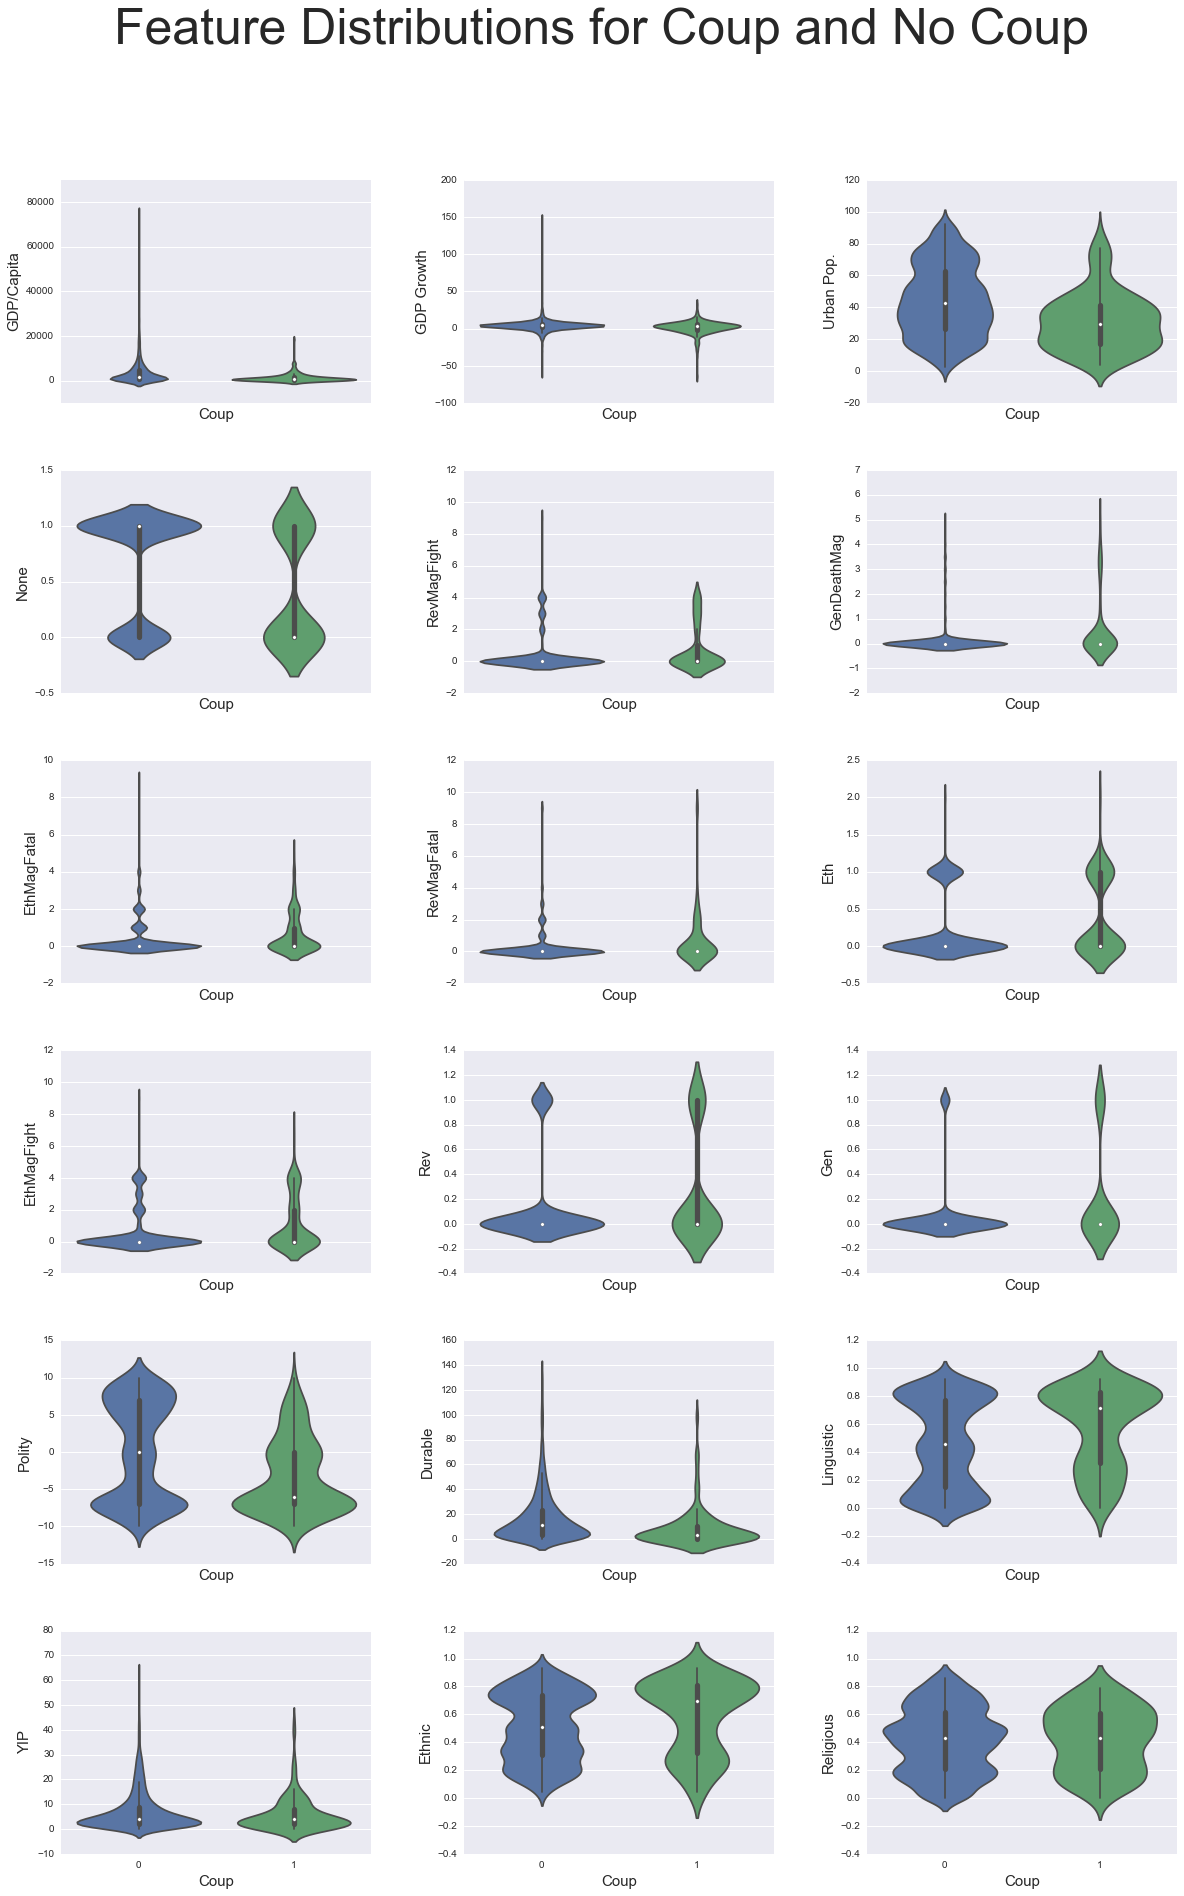

In [48]:
# To observe the differences in distribution of feactures for coup and no coup
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), \
      (ax13, ax14, ax15), (ax16, ax17, ax18)) = plt.subplots(nrows=6, ncols=3, \
        sharey=False, sharex=True, figsize=(20,30))
fig.suptitle("Feature Distributions for Coup and No Coup", size=50)

sns.set_style("whitegrid")
sns.violinplot(x='coup', y="gdppercap", data=DF, ax=ax1)
ax1.set_xlabel("Coup", fontsize=15)
ax1.set_ylabel("GDP/Capita", fontsize=15)  
    
sns.violinplot(x='coup', y="gdpgrowth", data=DF, ax=ax2)
ax2.set_xlabel("Coup", fontsize=15)
ax2.set_ylabel("GDP Growth", fontsize=15)

sns.violinplot(x='coup', y="urbanpop", data=DF, ax=ax3)
ax3.set_xlabel("Coup", fontsize=15)
ax3.set_ylabel("Urban Pop.", fontsize=15)

sns.violinplot(x='coup', y="none", data=DF, ax=ax4)
ax4.set_xlabel("Coup", fontsize=15)
ax4.set_ylabel("None", fontsize=15)

sns.violinplot(x='coup', y="revmagfight", data=DF, ax=ax5)
ax5.set_xlabel("Coup", fontsize=15)
ax5.set_ylabel("RevMagFight", fontsize=15)

sns.violinplot(x='coup', y="gendeathmag", data=DF, ax=ax6)
ax6.set_xlabel("Coup", fontsize=15)
ax6.set_ylabel("GenDeathMag", fontsize=15)

sns.violinplot(x='coup', y="ethmagfatal", data=DF, ax=ax7)
ax7.set_xlabel("Coup", fontsize=15)
ax7.set_ylabel("EthMagFatal", fontsize=15)

sns.violinplot(x='coup', y="revmagfatal", data=DF, ax=ax8)
ax8.set_xlabel("Coup", fontsize=15)
ax8.set_ylabel("RevMagFatal", fontsize=15)

sns.violinplot(x='coup', y="eth", data=DF, ax=ax9)
ax9.set_xlabel("Coup", fontsize=15)
ax9.set_ylabel("Eth", fontsize=15)

sns.violinplot(x='coup', y="ethmagfight", data=DF, ax=ax10)
ax10.set_xlabel("Coup", fontsize=15)
ax10.set_ylabel("EthMagFight", fontsize=15)

sns.violinplot(x='coup', y="rev", data=DF, ax=ax11)
ax11.set_xlabel("Coup", fontsize=15)
ax11.set_ylabel("Rev", fontsize=15)

sns.violinplot(x='coup', y="gen", data=DF, ax=ax12)
ax12.set_xlabel("Coup", fontsize=15)
ax12.set_ylabel("Gen", fontsize=15)

sns.violinplot(x='coup', y="polity2", data=DF, ax=ax13)
ax13.set_xlabel("Coup", fontsize=15)
ax13.set_ylabel("Polity", fontsize=15)

sns.violinplot(x='coup', y="durable", data=DF, ax=ax14)
ax14.set_xlabel("Coup", fontsize=15)
ax14.set_ylabel("Durable", fontsize=15)

sns.violinplot(x='coup', y="linguistic", data=DF, ax=ax15)
ax15.set_xlabel("Coup", fontsize=15)
ax15.set_ylabel("Linguistic", fontsize=15)

sns.violinplot(x='coup', y="yip", data=DF, ax=ax16)
ax16.set_xlabel("Coup", fontsize=15)
ax16.set_ylabel("YIP", fontsize=15)

sns.violinplot(x='coup', y="ethnic", data=DF, ax=ax17)
ax17.set_xlabel("Coup", fontsize=15)
ax17.set_ylabel("Ethnic", fontsize=15)

sns.violinplot(x='coup', y="religious", data=DF, ax=ax18)
ax18.set_xlabel("Coup", fontsize=15)
ax18.set_ylabel("Religious", fontsize=15)

fig.subplots_adjust(hspace=.3, wspace=.3)

In [49]:
# To split the dataframe into one with instances of a coup and another with instances of no coup
acoup = DF.loc[DF.coup==1]
nocoup = DF.loc[DF.coup==0]

In [50]:
#acoup.head()

In [51]:
#nocoup.head()

In [52]:
acoup.describe()

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
count,185.000000,185.000000,185.000000,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1391.189189,1.426973,31.588270,1.0,0.410811,0.762162,0.532432,0.637838,0.686486,0.378378,1.102703,0.254054,0.200000,-3.351351,8.664865,6.145946,0.585213,0.578602,0.420310
std,1991.146469,9.429349,18.434825,0.0,0.493316,1.390056,1.222092,1.039270,1.661286,0.508159,1.636952,0.436509,0.401085,4.882401,16.002245,7.148677,0.264902,0.287826,0.224918
min,15.000000,-64.050000,3.650000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.045400,0.000000,0.003500
25%,388.000000,-1.540000,17.220000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,2.000000,0.320000,0.322000,0.209000
50%,583.000000,3.040000,29.670000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,3.000000,4.000000,0.693200,0.719000,0.430700
75%,1537.000000,5.600000,41.460000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,10.000000,8.000000,0.808200,0.831600,0.612800
max,18497.000000,32.590000,86.980000,1.0,1.000000,4.000000,5.000000,5.000000,9.000000,2.000000,7.000000,1.000000,1.000000,10.000000,101.000000,44.000000,0.930200,0.922700,0.791600


In [53]:
nocoup.describe()

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
count,2861.000000,2861.000000,2861.000000,2861.0,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000,2861.000000
mean,3933.190493,4.160933,44.240566,0.0,0.664453,0.458231,0.150647,0.383782,0.307235,0.230339,0.678085,0.141209,0.064663,0.070605,17.478854,7.498777,0.510172,0.460221,0.415175
std,5817.963331,8.242379,22.407925,0.0,0.472264,1.231046,0.661391,0.905424,1.043284,0.430972,1.401362,0.348298,0.245973,6.646934,21.231425,8.476814,0.244877,0.314458,0.234026
min,10.000000,-62.080000,2.730000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.045400,0.000000,0.003500
25%,608.000000,1.760000,26.410000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,3.000000,2.000000,0.306900,0.151100,0.209000
50%,1759.000000,4.200000,42.520000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,4.000000,0.512200,0.458600,0.430700
75%,4839.000000,6.670000,62.720000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,23.000000,9.000000,0.735100,0.772500,0.615700
max,75117.000000,149.970000,92.140000,0.0,1.000000,9.000000,5.000000,9.000000,9.000000,2.000000,9.000000,1.000000,1.000000,10.000000,135.000000,63.000000,0.930200,0.922700,0.860300


In [54]:
# To test for statistical differences in the means of features for coup and no coup
features = ["gdppercap", "gdpgrowth", "urbanpop", "none", "revmagfight", 
            "gendeathmag", "ethmagfatal", "revmagfatal", "eth", 
            "ethmagfight", "rev", "gen", "polity2", "durable", 
            "yip", "ethnic", "linguistic", "religious"]

for i in features:
    print ttest_ind(acoup[i], nocoup[i])

Ttest_indResult(statistic=-5.919618873274282, pvalue=3.5867804925411991e-09)
Ttest_indResult(statistic=-4.3321568133553718, pvalue=1.5243048291309258e-05)
Ttest_indResult(statistic=-7.5167743330847685, pvalue=7.3408555191078861e-14)
Ttest_indResult(statistic=-7.0603065923278052, pvalue=2.0494248219305904e-12)
Ttest_indResult(statistic=3.2277506039335551, pvalue=0.0012609191611862298)
Ttest_indResult(statistic=7.1082422976939483, pvalue=1.4580017622241313e-12)
Ttest_indResult(statistic=3.6637775135583488, pvalue=0.00025275951632158582)
Ttest_indResult(statistic=4.5838409159708329, pvalue=4.7489193832549189e-06)
Ttest_indResult(statistic=4.4755356300293778, pvalue=7.9016166461748178e-06)
Ttest_indResult(statistic=3.9508956441405028, pvalue=7.9626746190126981e-05)
Ttest_indResult(statistic=4.198995599398363, pvalue=2.7578757789371637e-05)
Ttest_indResult(statistic=6.914485285799695, pvalue=5.6981771313569814e-12)
Ttest_indResult(statistic=-6.8827588518098972, pvalue=7.0993159573583768e-12

## Data Exploration

In [55]:
DF.groupby("polity2").mean()

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,durable,yip,ethnic,linguistic,religious
polity2,,,,,,,,,,,,,,,,,,
-10,9190.000000,8.205625,46.028750,0.031250,0.718750,0.625000,0.000000,0.000000,0.281250,0.000000,0.000000,0.281250,0.000000,21.250000,11.187500,0.509519,0.478419,0.333137
-9,2738.840580,4.097295,40.967681,0.077295,0.748792,0.130435,0.207729,0.299517,0.357488,0.193237,0.613527,0.062802,0.091787,23.294686,13.241546,0.526300,0.494781,0.406773
-8,3810.839623,4.242264,44.474434,0.047170,0.594340,0.613208,0.330189,0.320755,0.415094,0.207547,0.716981,0.216981,0.094340,22.094340,12.745283,0.547953,0.473160,0.354853
-7,2004.344771,4.393758,35.105507,0.102941,0.691176,0.295752,0.383987,0.442810,0.245098,0.232026,0.727124,0.084967,0.161765,19.571895,7.557190,0.569001,0.463629,0.435491
-6,3021.279570,4.877527,41.552527,0.059140,0.731183,0.462366,0.129032,0.204301,0.220430,0.107527,0.263441,0.155914,0.086022,26.301075,8.849462,0.506697,0.470518,0.310522
-5,1813.490909,3.964545,29.498182,0.090909,0.472727,0.854545,0.090909,0.600000,0.581818,0.472727,1.109091,0.236364,0.072727,9.672727,6.945455,0.509762,0.443276,0.396402
-4,1139.538462,3.460192,27.925192,0.134615,0.346154,0.365385,0.278846,0.826923,0.134615,0.576923,1.365385,0.096154,0.115385,8.596154,9.461538,0.564892,0.526631,0.467673
-3,2616.706522,4.622391,39.838478,0.043478,0.554348,0.880435,0.163043,0.423913,0.456522,0.315217,0.804348,0.228261,0.054348,5.804348,8.010870,0.470304,0.344417,0.357427
-2,2215.903226,4.330000,29.319516,0.112903,0.693548,0.758065,0.161290,0.177419,0.516129,0.112903,0.322581,0.258065,0.064516,6.822581,14.741935,0.677490,0.679982,0.427747


In [56]:
DF.groupby("coup").mean()

,gdppercap,gdpgrowth,urbanpop,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
coup,,,,,,,,,,,,,,,,,,
0,3933.190493,4.160933,44.240566,0.664453,0.458231,0.150647,0.383782,0.307235,0.230339,0.678085,0.141209,0.064663,0.070605,17.478854,7.498777,0.510172,0.460221,0.415175
1,1391.189189,1.426973,31.588270,0.410811,0.762162,0.532432,0.637838,0.686486,0.378378,1.102703,0.254054,0.200000,-3.351351,8.664865,6.145946,0.585213,0.578602,0.420310


## Random Forest Classifier

In [57]:
from sklearn.cross_validation import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.metrics import r2_score,accuracy_score,precision_score,recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_curve, auc

In [58]:
DF["country"] = DF["country"].astype("category")
cat_columns = DF.select_dtypes(['category']).columns
DF[cat_columns] = DF[cat_columns].apply(lambda x: x.cat.codes)

In [59]:
y = DF["coup"]
X = DF.drop(["coup"], axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [61]:
# rf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

# param_grid = { 
#                 'n_estimators': [100,200,300,400,500],
#                 'criterion': ["gini"],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'min_samples_split':[1,2,3,4,5,6]
#               }

# CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
# CV_rf.fit(X_train, y_train)
# print CV_rf.best_params_


In [66]:
cv = KFold(len(y_train), shuffle=False) 
print cv
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features="sprt", max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
print "Regular Decision Tree scores are:", rfScore
print "Regular Decision Tree average score is:", rfScore.mean()

sklearn.cross_validation.KFold(n=2132, n_folds=3, shuffle=False, random_state=None)


JoblibException: JoblibException
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/Lola/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/Users/Lola/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x1028cf230, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/Lola/...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x1028cf230, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/Lola/...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-08-18T11:44:00.708695', u'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', u'msg_type': u'execute_request', u'session': u'BE7789AA274648A38CA8C8331DD3369A', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['BE7789AA274648A38CA8C8331DD3369A']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-08-18T11:44:00.708695', u'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', u'msg_type': u'execute_request', u'session': u'BE7789AA274648A38CA8C8331DD3369A', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['BE7789AA274648A38CA8C8331DD3369A'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-08-18T11:44:00.708695', u'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', u'msg_type': u'execute_request', u'session': u'BE7789AA274648A38CA8C8331DD3369A', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', 'msg_type': u'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Print object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Print object>, <_ast.Print object>], cell_name='<ipython-input-66-38f024dd33ec>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2820 
   2821         try:
   2822             for i, node in enumerate(to_run_exec):
   2823                 mod = ast.Module([node])
   2824                 code = compiler(mod, cell_name, "exec")
-> 2825                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11b922830, file "<ipython-input-66-38f024dd33ec>", line 8>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11b922830, file "<ipython-input-66-38f024dd33ec>", line 8>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11b922830, file "<ipython-input-66-38f024dd33ec>", line 8>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Col1': 'country', 'Col2': ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', ...], 'Col3': 'country', 'Col4': ['1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', ...], 'Col5': 'country', 'Col6': ['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', ...], 'DF':       country  gdppercap  gdpgrowth  urbanpop  c...    0.4472     0.7363  

[3046 rows x 20 columns], 'Econ':           country  year  gdppercap  gdpgrowth
0 ...15      819.0       1.07

[8366 rows x 4 columns], 'Econ1':           country  year  gdppercap  gdpgrowth  u...9.0       1.07     32.38

[8272 rows x 5 columns], ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Col1': 'country', 'Col2': ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', ...], 'Col3': 'country', 'Col4': ['1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', ...], 'Col5': 'country', 'Col6': ['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', ...], 'DF':       country  gdppercap  gdpgrowth  urbanpop  c...    0.4472     0.7363  

[3046 rows x 20 columns], 'Econ':           country  year  gdppercap  gdpgrowth
0 ...15      819.0       1.07

[8366 rows x 4 columns], 'Econ1':           country  year  gdppercap  gdpgrowth  u...9.0       1.07     32.38

[8272 rows x 5 columns], ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/Users/Lola/Documents/Dami_repo/Capstone/starterCode/<ipython-input-66-38f024dd33ec> in <module>()
      3 rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
      4             max_depth=None, max_features="sprt", max_leaf_nodes=None,
      5             min_samples_leaf=1, min_samples_split=5,
      6             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
      7             oob_score=True, random_state=20, verbose=0, warm_start=False)
----> 8 rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
      9 print "Regular Decision Tree scores are:", rfScore
     10 print "Regular Decision Tree average score is:", rfScore.mean()
     11 
     12 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py in cross_val_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), X=      country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[2132 rows x 19 columns], y=2623    0
1417    0
944     0
3032    0
1993    ...   0
2673    0
2806    0
Name: coup, dtype: int64, scoring=None, cv=sklearn.cross_validation.KFold(n=2132, n_folds=3, shuffle=False, random_state=None), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
   1428     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
   1429                         pre_dispatch=pre_dispatch)
   1430     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
   1431                                               train, test, verbose, None,
   1432                                               fit_params)
-> 1433                       for train, test in cv)
        cv = sklearn.cross_validation.KFold(n=2132, n_folds=3, shuffle=False, random_state=None)
   1434     return np.array(scores)[:, 0]
   1435 
   1436 
   1437 class FitFailedWarning(RuntimeWarning):

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
JoblibValueError                                   Thu Aug 18 11:44:05 2016
PID: 18390                   Python 2.7.12: /Users/Lola/anaconda/bin/python
...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False),       country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[2132 rows x 19 columns], 2623    0
1417    0
944     0
3032    0
1993    ...   0
2673    0
2806    0
Name: coup, dtype: int64, <function _passthrough_scorer>, array([ 711,  712,  713, ..., 2129, 2130, 2131]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    702, 703, 704, 705, 706, 707, 708, 709, 710]), 0, None, None)
        kwargs = {}
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False),       country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[2132 rows x 19 columns], 2623    0
1417    0
944     0
3032    0
1993    ...   0
2673    0
2806    0
Name: coup, dtype: int64, <function _passthrough_scorer>, array([ 711,  712,  713, ..., 2129, 2130, 2131]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    702, 703, 704, 705, 706, 707, 708, 709, 710]), 0, None, None), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), X=      country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[2132 rows x 19 columns], y=2623    0
1417    0
944     0
3032    0
1993    ...   0
2673    0
2806    0
Name: coup, dtype: int64, scorer=<function _passthrough_scorer>, train=array([ 711,  712,  713, ..., 2129, 2130, 2131]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    702, 703, 704, 705, 706, 707, 708, 709, 710]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, error_score='raise')
   1526 
   1527     try:
   1528         if y_train is None:
   1529             estimator.fit(X_train, **fit_params)
   1530         else:
-> 1531             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method RandomForestClassifier.fit of Rand...e, random_state=20, verbose=0, warm_start=False)>
        X_train =       country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[1421 rows x 19 columns]
        y_train = 1714    0
207     0
2472    0
1530    0
2105    ...   0
2673    0
2806    0
Name: coup, dtype: int64
        fit_params = {}
   1532 
   1533     except Exception as e:
   1534         if error_score == 'raise':
   1535             raise

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), X=array([[  3.80000000e+01,   1.10800000e+04,   1.....47299981e-01,   3.38600010e-01]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), sample_weight=None)
    285             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    286                              backend="threading")(
    287                 delayed(_parallel_build_trees)(
    288                     t, self, X, y, sample_weight, i, len(trees),
    289                     verbose=self.verbose, class_weight=self.class_weight)
--> 290                 for i, t in enumerate(trees))
        i = 99
    291 
    292             # Collect newly grown trees
    293             self.estimators_.extend(trees)
    294 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in retrieve(self=Parallel(n_jobs=-1))
    752                     # In case we had to terminate a managed pool, let
    753                     # us start a new one to ensure that subsequent calls
    754                     # to __call__ on the same Parallel instance will get
    755                     # a working pool as they expect.
    756                     self._initialize_pool()
--> 757                 raise exception
        exception = JoblibValueError
_______________________________..._________________________________________________
    758 
    759     def __call__(self, iterable):
    760         if self._jobs:
    761             raise ValueError('This Parallel instance is already running')

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/Lola/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/Users/Lola/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x1028cf230, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/Lola/...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x1028cf230, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/Lola/...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-08-18T11:44:00.708695', u'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', u'msg_type': u'execute_request', u'session': u'BE7789AA274648A38CA8C8331DD3369A', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['BE7789AA274648A38CA8C8331DD3369A']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-08-18T11:44:00.708695', u'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', u'msg_type': u'execute_request', u'session': u'BE7789AA274648A38CA8C8331DD3369A', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['BE7789AA274648A38CA8C8331DD3369A'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-08-18T11:44:00.708695', u'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', u'msg_type': u'execute_request', u'session': u'BE7789AA274648A38CA8C8331DD3369A', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'5FF180D9677A4DC9B81F27609D36F84E', 'msg_type': u'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'cv = KFold(len(y_train), shuffle=False) \nprin...Decision Tree average score is:", rfScore.mean()', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Print object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Print object>, <_ast.Print object>], cell_name='<ipython-input-66-38f024dd33ec>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2820 
   2821         try:
   2822             for i, node in enumerate(to_run_exec):
   2823                 mod = ast.Module([node])
   2824                 code = compiler(mod, cell_name, "exec")
-> 2825                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11b922830, file "<ipython-input-66-38f024dd33ec>", line 8>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11b922830, file "<ipython-input-66-38f024dd33ec>", line 8>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11b922830, file "<ipython-input-66-38f024dd33ec>", line 8>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Col1': 'country', 'Col2': ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', ...], 'Col3': 'country', 'Col4': ['1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', ...], 'Col5': 'country', 'Col6': ['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', ...], 'DF':       country  gdppercap  gdpgrowth  urbanpop  c...    0.4472     0.7363  

[3046 rows x 20 columns], 'Econ':           country  year  gdppercap  gdpgrowth
0 ...15      819.0       1.07

[8366 rows x 4 columns], 'Econ1':           country  year  gdppercap  gdpgrowth  u...9.0       1.07     32.38

[8272 rows x 5 columns], ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Col1': 'country', 'Col2': ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', ...], 'Col3': 'country', 'Col4': ['1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', ...], 'Col5': 'country', 'Col6': ['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', ...], 'DF':       country  gdppercap  gdpgrowth  urbanpop  c...    0.4472     0.7363  

[3046 rows x 20 columns], 'Econ':           country  year  gdppercap  gdpgrowth
0 ...15      819.0       1.07

[8366 rows x 4 columns], 'Econ1':           country  year  gdppercap  gdpgrowth  u...9.0       1.07     32.38

[8272 rows x 5 columns], ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/Users/Lola/Documents/Dami_repo/Capstone/starterCode/<ipython-input-66-38f024dd33ec> in <module>()
      3 rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
      4             max_depth=None, max_features="sprt", max_leaf_nodes=None,
      5             min_samples_leaf=1, min_samples_split=5,
      6             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
      7             oob_score=True, random_state=20, verbose=0, warm_start=False)
----> 8 rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
      9 print "Regular Decision Tree scores are:", rfScore
     10 print "Regular Decision Tree average score is:", rfScore.mean()
     11 
     12 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py in cross_val_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), X=      country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[2132 rows x 19 columns], y=2623    0
1417    0
944     0
3032    0
1993    ...   0
2673    0
2806    0
Name: coup, dtype: int64, scoring=None, cv=sklearn.cross_validation.KFold(n=2132, n_folds=3, shuffle=False, random_state=None), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
   1428     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
   1429                         pre_dispatch=pre_dispatch)
   1430     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
   1431                                               train, test, verbose, None,
   1432                                               fit_params)
-> 1433                       for train, test in cv)
        cv = sklearn.cross_validation.KFold(n=2132, n_folds=3, shuffle=False, random_state=None)
   1434     return np.array(scores)[:, 0]
   1435 
   1436 
   1437 class FitFailedWarning(RuntimeWarning):

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    761             raise ValueError('This Parallel instance is already running')
    762         # A flag used to abort the dispatching of jobs in case an
    763         # exception is found
    764         self._aborting = False
    765         if not self._managed_pool:
--> 766             n_jobs = self._initialize_pool()
        n_jobs = undefined
        self._initialize_pool = <bound method Parallel._initialize_pool of Parallel(n_jobs=-1)>
    767         else:
    768             n_jobs = self._effective_n_jobs()
    769 
    770         if self.batch_size == 'auto':

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in _initialize_pool(self=Parallel(n_jobs=-1))
    532                     verbose=max(0, self.verbose - 50),
    533                 )
    534                 if self._mp_context is not None:
    535                     # Use Python 3.4+ multiprocessing context isolation
    536                     poolargs['context'] = self._mp_context
--> 537                 self._pool = MemmapingPool(n_jobs, **poolargs)
        self._pool = None
        n_jobs = 4
        poolargs = {'max_nbytes': 1048576, 'mmap_mode': 'r', 'temp_folder': None, 'verbose': 0}
    538 
    539                 # We are using multiprocessing, we also want to capture
    540                 # KeyboardInterrupts
    541                 self.exceptions.extend([KeyboardInterrupt, WorkerInterrupt])

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py in __init__(self=<sklearn.externals.joblib.pool.MemmapingPool object>, processes=4, temp_folder='/var/folders/_m/rrxkm1q17cncwntfz566swcr0000gn/T', max_nbytes=1048576, mmap_mode='r', forward_reducers={<class 'numpy.core.memmap.memmap'>: <function reduce_memmap>, <type 'numpy.ndarray'>: <sklearn.externals.joblib.pool.ArrayMemmapReducer object>}, backward_reducers={<class 'numpy.core.memmap.memmap'>: <function reduce_memmap>, <type 'numpy.ndarray'>: <sklearn.externals.joblib.pool.ArrayMemmapReducer object>}, verbose=0, context_id=None, prewarm=False, **kwargs={})
    575         poolargs = dict(
    576             processes=processes,
    577             forward_reducers=forward_reducers,
    578             backward_reducers=backward_reducers)
    579         poolargs.update(kwargs)
--> 580         super(MemmapingPool, self).__init__(**poolargs)
        self.__init__ = <bound method MemmapingPool.__init__ of <sklearn.externals.joblib.pool.MemmapingPool object>>
        poolargs = {'backward_reducers': {<class 'numpy.core.memmap.memmap'>: <function reduce_memmap>, <type 'numpy.ndarray'>: <sklearn.externals.joblib.pool.ArrayMemmapReducer object>}, 'forward_reducers': {<class 'numpy.core.memmap.memmap'>: <function reduce_memmap>, <type 'numpy.ndarray'>: <sklearn.externals.joblib.pool.ArrayMemmapReducer object>}, 'processes': 4}
    581 
    582     def terminate(self):
    583         super(MemmapingPool, self).terminate()
    584         delete_folder(self._temp_folder)

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py in __init__(self=<sklearn.externals.joblib.pool.MemmapingPool object>, processes=4, forward_reducers={<class 'numpy.core.memmap.memmap'>: <function reduce_memmap>, <type 'numpy.ndarray'>: <sklearn.externals.joblib.pool.ArrayMemmapReducer object>}, backward_reducers={<class 'numpy.core.memmap.memmap'>: <function reduce_memmap>, <type 'numpy.ndarray'>: <sklearn.externals.joblib.pool.ArrayMemmapReducer object>}, **kwargs={})
    413             backward_reducers = dict()
    414         self._forward_reducers = forward_reducers
    415         self._backward_reducers = backward_reducers
    416         poolargs = dict(processes=processes)
    417         poolargs.update(kwargs)
--> 418         super(PicklingPool, self).__init__(**poolargs)
        self.__init__ = <bound method MemmapingPool.__init__ of <sklearn.externals.joblib.pool.MemmapingPool object>>
        poolargs = {'processes': 4}
    419 
    420     def _setup_queues(self):
    421         context = getattr(self, '_ctx', mp)
    422         self._inqueue = CustomizablePicklingQueue(context,

...........................................................................
/Users/Lola/anaconda/lib/python2.7/multiprocessing/pool.py in __init__(self=<sklearn.externals.joblib.pool.MemmapingPool object>, processes=4, initializer=None, initargs=(), maxtasksperchild=None)
    154         if initializer is not None and not hasattr(initializer, '__call__'):
    155             raise TypeError('initializer must be a callable')
    156 
    157         self._processes = processes
    158         self._pool = []
--> 159         self._repopulate_pool()
        self._repopulate_pool = <bound method MemmapingPool._repopulate_pool of ...earn.externals.joblib.pool.MemmapingPool object>>
    160 
    161         self._worker_handler = threading.Thread(
    162             target=Pool._handle_workers,
    163             args=(self, )

...........................................................................
/Users/Lola/anaconda/lib/python2.7/multiprocessing/pool.py in _repopulate_pool(self=<sklearn.externals.joblib.pool.MemmapingPool object>)
    218                                    self._initargs, self._maxtasksperchild)
    219                             )
    220             self._pool.append(w)
    221             w.name = w.name.replace('Process', 'PoolWorker')
    222             w.daemon = True
--> 223             w.start()
        w.start = <bound method Process.start of <Process(PoolWorker-1, started daemon)>>
    224             debug('added worker')
    225 
    226     def _maintain_pool(self):
    227         """Clean up any exited workers and start replacements for them.

...........................................................................
/Users/Lola/anaconda/lib/python2.7/multiprocessing/process.py in start(self=<Process(PoolWorker-1, started daemon)>)
    125         _cleanup()
    126         if self._Popen is not None:
    127             Popen = self._Popen
    128         else:
    129             from .forking import Popen
--> 130         self._popen = Popen(self)
        self._popen = None
        Popen = <class 'multiprocessing.forking.Popen'>
        self = <Process(PoolWorker-1, started daemon)>
    131         _current_process._children.add(self)
    132 
    133     def terminate(self):
    134         '''

...........................................................................
/Users/Lola/anaconda/lib/python2.7/multiprocessing/forking.py in __init__(self=<multiprocessing.forking.Popen object>, process_obj=<Process(PoolWorker-1, started daemon)>)
    121             self.pid = os.fork()
    122             if self.pid == 0:
    123                 if 'random' in sys.modules:
    124                     import random
    125                     random.seed()
--> 126                 code = process_obj._bootstrap()
        code = undefined
        process_obj._bootstrap = <bound method Process._bootstrap of <Process(PoolWorker-1, started daemon)>>
    127                 sys.stdout.flush()
    128                 sys.stderr.flush()
    129                 os._exit(code)
    130 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/multiprocessing/process.py in _bootstrap(self=<Process(PoolWorker-1, started daemon)>)
    253             _current_process = self
    254             util._finalizer_registry.clear()
    255             util._run_after_forkers()
    256             util.info('child process calling self.run()')
    257             try:
--> 258                 self.run()
        self.run = <bound method Process.run of <Process(PoolWorker-1, started daemon)>>
    259                 exitcode = 0
    260             finally:
    261                 util._exit_function()
    262         except SystemExit, e:

...........................................................................
/Users/Lola/anaconda/lib/python2.7/multiprocessing/process.py in run(self=<Process(PoolWorker-1, started daemon)>)
    109     def run(self):
    110         '''
    111         Method to be run in sub-process; can be overridden in sub-class
    112         '''
    113         if self._target:
--> 114             self._target(*self._args, **self._kwargs)
        self._target = <function worker>
        self._args = (<sklearn.externals.joblib.pool.CustomizablePicklingQueue object>, <sklearn.externals.joblib.pool.CustomizablePicklingQueue object>, None, (), None)
        self._kwargs = {}
    115 
    116     def start(self):
    117         '''
    118         Start child process

...........................................................................
/Users/Lola/anaconda/lib/python2.7/multiprocessing/pool.py in worker(inqueue=<sklearn.externals.joblib.pool.CustomizablePicklingQueue object>, outqueue=<sklearn.externals.joblib.pool.CustomizablePicklingQueue object>, initializer=None, initargs=(), maxtasks=None)
    108             debug('worker got sentinel -- exiting')
    109             break
    110 
    111         job, i, func, args, kwds = task
    112         try:
--> 113             result = (True, func(*args, **kwds))
        result = undefined
        func = <sklearn.externals.joblib.parallel.SafeFunction object>
        args = ()
        kwds = {}
    114         except Exception, e:
    115             result = (False, e)
    116         try:
    117             put((job, i, result))

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.SafeFunction object>, *args=(), **kwargs={})
    125     def __init__(self, func):
    126         self.func = func
    127 
    128     def __call__(self, *args, **kwargs):
    129         try:
--> 130             return self.func(*args, **kwargs)
        self.func = <sklearn.externals.joblib.parallel.BatchedCalls object>
        args = ()
        kwargs = {}
    131         except KeyboardInterrupt:
    132             # We capture the KeyboardInterrupt and reraise it as
    133             # something different, as multiprocessing does not
    134             # interrupt processing for a KeyboardInterrupt

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False),       country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[2132 rows x 19 columns], 2623    0
1417    0
944     0
3032    0
1993    ...   0
2673    0
2806    0
Name: coup, dtype: int64, <function _passthrough_scorer>, array([ 711,  712,  713, ..., 2129, 2130, 2131]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    702, 703, 704, 705, 706, 707, 708, 709, 710]), 0, None, None)
        kwargs = {}
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False),       country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[2132 rows x 19 columns], 2623    0
1417    0
944     0
3032    0
1993    ...   0
2673    0
2806    0
Name: coup, dtype: int64, <function _passthrough_scorer>, array([ 711,  712,  713, ..., 2129, 2130, 2131]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    702, 703, 704, 705, 706, 707, 708, 709, 710]), 0, None, None), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), X=      country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[2132 rows x 19 columns], y=2623    0
1417    0
944     0
3032    0
1993    ...   0
2673    0
2806    0
Name: coup, dtype: int64, scorer=<function _passthrough_scorer>, train=array([ 711,  712,  713, ..., 2129, 2130, 2131]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    702, 703, 704, 705, 706, 707, 708, 709, 710]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, error_score='raise')
   1526 
   1527     try:
   1528         if y_train is None:
   1529             estimator.fit(X_train, **fit_params)
   1530         else:
-> 1531             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method RandomForestClassifier.fit of Rand...e, random_state=20, verbose=0, warm_start=False)>
        X_train =       country  gdppercap  gdpgrowth  urbanpop  n...    0.5473     0.3386  

[1421 rows x 19 columns]
        y_train = 1714    0
207     0
2472    0
1530    0
2105    ...   0
2673    0
2806    0
Name: coup, dtype: int64
        fit_params = {}
   1532 
   1533     except Exception as e:
   1534         if error_score == 'raise':
   1535             raise

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), X=array([[  3.80000000e+01,   1.10800000e+04,   1.....47299981e-01,   3.38600010e-01]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), sample_weight=None)
    285             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    286                              backend="threading")(
    287                 delayed(_parallel_build_trees)(
    288                     t, self, X, y, sample_weight, i, len(trees),
    289                     verbose=self.verbose, class_weight=self.class_weight)
--> 290                 for i, t in enumerate(trees))
        i = 99
    291 
    292             # Collect newly grown trees
    293             self.estimators_.extend(trees)
    294 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Aug 18 11:44:02 2016
PID: 18390                   Python 2.7.12: /Users/Lola/anaconda/bin/python
...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeClassifier(class_weight=None, criter...t=False, random_state=378518883, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), array([[  3.80000000e+01,   1.10800000e+04,   1.....47299981e-01,   3.38600010e-01]], dtype=float32), array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), None, 0, 100)
        kwargs = {'class_weight': None, 'verbose': 0}
        self.items = [(<function _parallel_build_trees>, (DecisionTreeClassifier(class_weight=None, criter...t=False, random_state=378518883, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), array([[  3.80000000e+01,   1.10800000e+04,   1.....47299981e-01,   3.38600010e-01]], dtype=float32), array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), None, 0, 100), {'class_weight': None, 'verbose': 0})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=DecisionTreeClassifier(class_weight=None, criter...t=False, random_state=378518883, splitter='best'), forest=RandomForestClassifier(bootstrap=True, class_wei...ue, random_state=20, verbose=0, warm_start=False), X=array([[  3.80000000e+01,   1.10800000e+04,   1.....47299981e-01,   3.38600010e-01]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), sample_weight=None, tree_idx=0, n_trees=100, verbose=0, class_weight=None)
    111                 warnings.simplefilter('ignore', DeprecationWarning)
    112                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    113         elif class_weight == 'balanced_subsample':
    114             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    115 
--> 116         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeClassifier.fit of Deci...=False, random_state=378518883, splitter='best')>
        X = array([[  3.80000000e+01,   1.10800000e+04,   1.....47299981e-01,   3.38600010e-01]], dtype=float32)
        y = array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])
        sample_weight = None
        curr_sample_weight = array([ 0.,  1.,  1., ...,  0.,  0.,  1.])
    117     else:
    118         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    119 
    120     return tree

...........................................................................
/Users/Lola/anaconda/lib/python2.7/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...t=False, random_state=378518883, splitter='best'), X=array([[  3.80000000e+01,   1.10800000e+04,   1.....47299981e-01,   3.38600010e-01]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), sample_weight=array([ 0.,  1.,  1., ...,  0.,  0.,  1.]), check_input=False, X_idx_sorted=None)
    219                 max_features = max(1, int(np.sqrt(self.n_features_)))
    220             elif self.max_features == "log2":
    221                 max_features = max(1, int(np.log2(self.n_features_)))
    222             else:
    223                 raise ValueError(
--> 224                     'Invalid value for max_features. Allowed string '
    225                     'values are "auto", "sqrt" or "log2".')
    226         elif self.max_features is None:
    227             max_features = self.n_features_
    228         elif isinstance(self.max_features, (numbers.Integral, np.integer)):

ValueError: Invalid value for max_features. Allowed string values are "auto", "sqrt" or "log2".
___________________________________________________________________________
___________________________________________________________________________

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2
from patsy import dmatrices
from sklearn import metrics

In [ ]:
y, X = dmatrices("coup ~ gdppercap + gdpgrowth + urbanpop + none + revmagfight + gendeathmag + \
                  ethmagfatal + revmagfatal + eth + ethmagfight + rev + gen + polity2 + durable + \
                  yip + ethnic + linguistic + religious", DF, return_type="dataframe")
X.columns

In [ ]:
y = np.ravel(y)

In [ ]:
lr = LogisticRegression()
model = lr.fit(X,y)

model.score(X, y)

In [ ]:
model.coef_

In [ ]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

## Test-Train-Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = lr.fit(X_train, y_train)

In [ ]:
predicted = model2.predict(X_test)
probs = model2.predict_proba(X_test)

In [ ]:
predictions = pd.DataFrame()
predictions["Actual"] = y_test
predictions["Predicted"] = predicted
predictions["ProbsPos"], predictions["ProbsNeg"] = zip(*probs)

In [ ]:
threshold = 0.2
predictions['threshPred'] = [0 if x < threshold else 1 for x in predictions['ProbsPos']]

In [ ]:
print metrics.accuracy_score(y_test, predictions["threshPred"])
print metrics.roc_auc_score(y_test, predictions["threshPred"])

In [ ]:
print pd.crosstab(predictions["Actual"], predictions['threshPred'], rownames=["Actual"])
print metrics.classification_report(predictions["Actual"], predictions['threshPred'])

Score: | 15/30
------------|---------
Identify: Create executive summary                | 3
Acquire: Demonstrate how you imported, queried, and sorted your data            | 3
Parse: Identify any outliers, define variables                | 2
Mine: Perform statistical analysis, correlate data                | 3
Refine: Describe and plot your data                | 2
Model: Perform model (train subset as needed)                | 1
Model: Tune and evaluate model                | 0
Present: Discuss model selection and implementation process                | 0
Present: Interpret findings and relate to goals/criteria                | 1
Present: Create recommendations for stakeholders & summarize next steps        | 0
Bonus! Deploy: Discuss how to deploy model in production environment |